In [20]:
import time
import os
import math
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
import shutil
import imageio
from PIL import Image, ImageDraw
import random

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_DAT import AutoDAT
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.utilities import *
from lib.file.ROI_writer import ROIFileWriter

###########################################
# Make a series of 1-frame measure windows from PhotoZ into a movie
# Asks user to annotate DIC/Fluorescence images for electrode + layer and barrel boundaries
#       Puts this metadata into ROI .dat files
# Uses DIC-to-ZDA frame mapping (rotation and scaling) to annotate the PhotoZ frames
# Uses autoPhotoZ to take frame images for move
#  - 8/24/23: 
#        Support any number of barrels.
#        add ROI generation: layer/barrel ROIs
###########################################

In [21]:
# Load data, not from Drive for Desktop since PhotoZ complains about loading zda from Drive
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/"
camera_program = 4

# annotation settings
skip_draw_annotations = True  # If True, don't draw any new annotations

# Movie maker settings
enable_photoZ_interact = True
initialize_photoZ = False

In [22]:
# set up PhotoZ (open it manually)
aPhz = AutoPhotoZ(data_dir=data_dir)
if initialize_photoZ and enable_photoZ_interact:
    aPhz.prepare_photoZ()

In [ ]:
stim_df = {
    'Date': [],
    "Slice_Loc": [],
    'stim_distance1': [], # distance to L4-L5 boundary
    'stim_distance2': [] # distance to neighboring barrel (in final CSV, this is 0 if home barrel)
}
already_drawn_slic_loc = {}


 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24
['02_01_01.zda', '02_02_01.zda', '02_03_01.zda', '04_01_01.zda', '04_02_01.zda', '04_02_02.zda', '04_03_01.zda', '04_03_02.zda', '05_01_01.zda', '05_01_02.zda', '05_02_01.zda']

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/02_01_01.zda
Already annotated  5/29/24_2_1 , skipping.

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/02_02_01.zda
Already annotated  5/29/24_2_2 , skipping.

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/02_03_01.zda
Already annotated  5/29/24_2_3 , skipping.

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/04_01_01.zda
Already annotated  5/29/24_4_1 , skipping.

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/04_02_01.zda
Already annotated  5/29/24_4_2 , skipping.

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/04_02_02.zda
Alrea

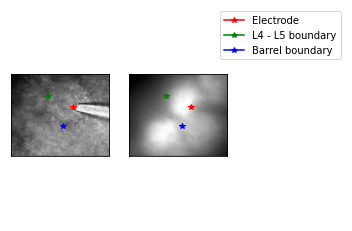

Distance1 (L4 - L5 boundary): 118.98936153258258
Distance2 (Barrel boundary): 92.13796816724575

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/06-03-24/02_04_01.zda
2 4


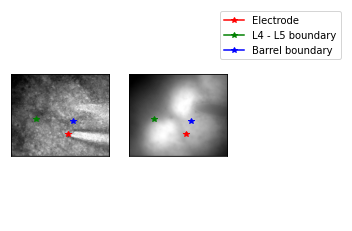

Distance1 (L4 - L5 boundary): 153.42072891024299
Distance2 (Barrel boundary): 60.02441888215806

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/06-03-24/02_05_01.zda
2 5


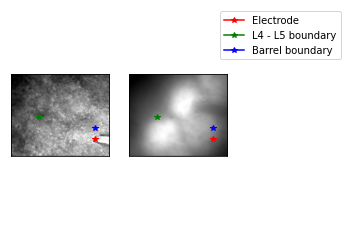

Distance1 (L4 - L5 boundary): 258.52527356462235
Distance2 (Barrel boundary): 47.96063895425558

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/06-03-24/03_01_01.zda
3 1


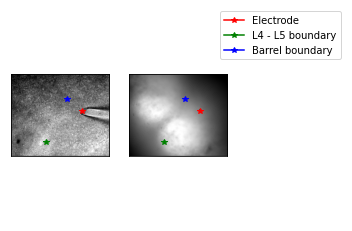

Distance1 (L4 - L5 boundary): 202.4310509541569
Distance2 (Barrel boundary): 84.30897491403783

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/06-03-24/03_02_01.zda
3 2


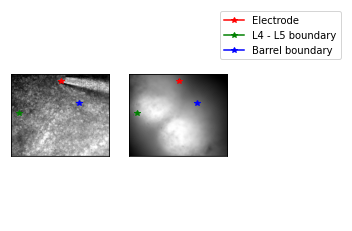

Distance1 (L4 - L5 boundary): 228.5295801686541
Distance2 (Barrel boundary): 123.15840928915047

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/06-04-24
['03_01_01.zda', '04_01_01.zda', '04_02_01.zda', 'analysis03_01_01', 'analysis04_01_01', 'analysis04_02_01']

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/06-04-24/03_01_01.zda
3 1


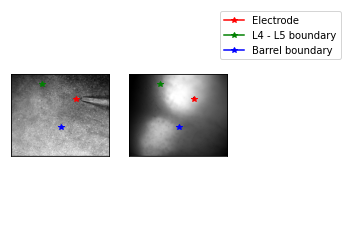

Distance1 (L4 - L5 boundary): 160.29031378682103
Distance2 (Barrel boundary): 133.9927509003226

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/06-04-24/04_01_01.zda
4 1


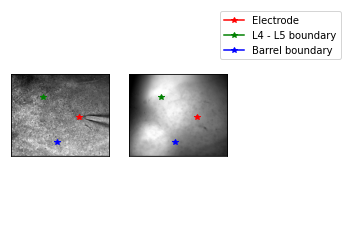

Distance1 (L4 - L5 boundary): 178.42923117886886
Distance2 (Barrel boundary): 140.76511983828743

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/06-04-24/04_02_01.zda
4 2


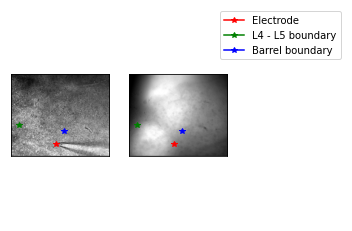

Distance1 (L4 - L5 boundary): 181.13771431262109
Distance2 (Barrel boundary): 65.72129699463736


,Date,Slice_Loc,stim_distance1,stim_distance2
0,5/29/24,2_1,60.813524,82.793827
1,5/29/24,2_2,121.039039,52.296078
2,5/29/24,2_3,121.041936,145.522129
3,5/29/24,4_1,120.001227,78.297929
4,5/29/24,4_2,154.832646,103.624931
5,5/29/24,5_1,191.644902,108.093227
6,5/29/24,5_2,166.888653,73.996707
7,5/31/24,1_1,112.271697,144.845388
8,5/31/24,1_2,161.770051,115.913966
9,5/31/24,2_1,167.660973,117.152856


In [29]:
# First ask user to annotate some images with:
#       - Electrode loc 
#       - L4 - L5 boundary
#       - Barrel boundary that is being crossed
# Calculate:
#       - Distance from electrode to L4 boundary (distance1)
#       - Distance from electrode to neighboring barrel (distance2)
# This will be used to calculate distance from electrode to L4 boundary and from electrode to neighboring barrel


for subdir, dirs, files in os.walk(data_dir):
    if skip_draw_annotations:
        continue
    if 'notUsable' in subdir:
        continue
    if 'hidden' in subdir:
        continue
    if 'dic' in dirs and 'selected_zda' in dirs:
        print("\n", subdir)
        dic_dir = subdir + "/dic/"
        selected_zda_dir = subdir + "/selected_zda/"
        
        # optionally process date
        date = ""
        try:
            char_select = -len('dd-mm-yyyy')
            date = subdir.split("/")[-1][char_select:]
            date = [int(x) for x in date.split("-")]
            date = "/".join([str(d) for d in date])
        except Exception as e:
            print(e, "could not process date.")

        # take selected zda and expand into separate subdir for each zda file
        print(os.listdir(selected_zda_dir))
        for zda_file in os.listdir(selected_zda_dir):
            if zda_file.endswith('.zda'):
                rec_id = zda_file.split('.')[0]
                print("\n", subdir + "/" + zda_file)
                slic_id, loc_id, _ = [int(x) for x in rec_id.split("_")]
                annotate_id = date + "_" + str(slic_id) + "_" + str(loc_id)
                if annotate_id in already_drawn_slic_loc:
                    print("Already annotated ", annotate_id, ", skipping.")
                    continue
                already_drawn_slic_loc[annotate_id] = True

                # read in 8-bit single TIF images to array, apply same cropping/binning
                image_data = {}
                cam_settings = CameraSettings().get_program_settings(camera_program)
                binning = int(2048 / 400) # if want size similar to RLI
                TIFLoader(dic_dir, 
                          cam_settings, 
                          binning, 
                          crop=False, 
                          flip_horiz=True).load_files(image_data, 
                                                      slice_target=slic_id)

                img_aligner = ImageAlign()

                for slic in image_data:
                    for loc in image_data[slic]:
                        if slic != slic_id or loc != loc_id:
                            continue
                        print(slic, loc)

                        # DICs
                        fluor = None
                        if 'f' in image_data[slic][loc]:
                            fluor = image_data[slic][loc]['f']
                        elif 'fe' in image_data[slic][loc]:
                            fluor = image_data[slic][loc]['fe']
                        # img = image_data[slic][loc]['i']

                        dic_electrode = None
                        if 'e' in image_data[slic][loc]:
                            dic_electrode = image_data[slic][loc]['e']
                        else:
                            dic_electrode = fluor

                        dic_electrode = np.array(dic_electrode, dtype=np.uint8)
                        orig_arr_shape = dic_electrode.shape

                        # ask user to select site of stim and layer/barrel borders
                        #       - Distance from electrode to L4 boundary (distance1)
                        #       - Distance from electrode to neighboring barrel (distance2)
                        if not skip_draw_annotations:
                            window_title = date + " " + rec_id

                            # ask user to select electrode
                            dic_electrode, electrode_coords = img_aligner.draw_electrode_on_image(
                                dic_electrode, 
                                window_title + " Electrode")
                            dic_electrode = np.array(dic_electrode)

                            # mark the electrode location into fluor image
                            x_el, y_el = electrode_coords['electrode']
                            for dx in range(-5, 5):
                                for dy in range(-5, 5):
                                    if x_el + dx >= 0 and x_el + dx < fluor.shape[1] and y_el + dy >= 0 and y_el + dy < fluor.shape[0]:
                                        fluor[int(y_el) + dy, int(x_el) + dx] = 0

                            # ask user to select L4 - L5 boundary
                            distance1_boundary, distance1_coords = img_aligner.draw_electrode_on_image(
                                fluor,
                                window_title + " Distance1 Boundary (L4 - L5 boundary)")
                            distance1_boundary = np.array(distance1_boundary)

                            # ask user to select barrel boundary
                            distance2_boundary, distance2_coords = img_aligner.draw_electrode_on_image(
                                fluor,
                                window_title + " Distance2 Boundary (Barrel boundary)")
                            distance2_boundary = np.array(distance2_boundary)
                            
                            # make 1 row of 2 subplots
                            fig, axes = plt.subplots(1, 3)
                            axes[0].imshow(dic_electrode, cmap='gray')
                            axes[1].imshow(fluor, cmap='gray')
                            
                            x_d1, y_d1 = distance1_coords['electrode']
                            x_d2, y_d2 = distance2_coords['electrode']

                            for ax in axes[:2]:
                                l1, = ax.plot(x_el, y_el, marker="*", color='red', label="Electrode")
                                l2, = ax.plot(x_d1, y_d1, marker="*", color='green', label="L4 - L5 boundary")
                                l3, = ax.plot(x_d2, y_d2, marker="*", color='blue', label="Barrel boundary")
                                ax.set_yticks([])
                                ax.set_xticks([])


                            axes[2].legend(handles=[l1, l2, l3],
                                           labels=["Electrode", "L4 - L5 boundary", "Barrel boundary"])
                            axes[2].axis('off')
                            plt.show()

                            try:
                                os.makedirs(output_dir)
                            except OSError:
                                pass

                            # no need to transform the coordinates, just calculate distances and convert px -> microns
                            dic_um_per_px = 425 / fluor.shape[1]
                            distance1 = Line([x_el, y_el], [x_d1, y_d1]).get_length() * dic_um_per_px
                            distance2 = Line([x_el, y_el], [x_d2, y_d2]).get_length() * dic_um_per_px
                            print("Distance1 (L4 - L5 boundary):", distance1)
                            print("Distance2 (Barrel boundary):", distance2)

                            # append data to Dataframe to write to CSV
                            stim_df["Date"].append(date)
                            stim_df["Slice_Loc"].append(str(slic) + "_" + str(loc))
                            stim_df["stim_distance1"].append(distance1)
                            stim_df["stim_distance2"].append(distance2)
                            
                            
stim_df = pd.DataFrame(stim_df)
stim_df


In [30]:
if skip_draw_annotations:
    # load from CSV
    stim_df = pd.read_csv(data_dir + "sagittal_crossing_with_distances.csv")
else:
    # write df to CSV
    stim_df.to_csv(data_dir + "sagittal_crossing_with_distances.csv", index=False)

In [ ]:
# now aggregate data for each barrel ROI
final_df = pd.DataFrame(columns=['Date', "Slice_Loc", "Barrel_ROI_ID"
                           "Slice_Edge", "Most_Caudal_Barrel", "Stim Location",
                           "Actual Stim Time (ms)",
                           "Stim Barrel",
                           "Barrel_Area",
                           "Responding_Area",
                           'stim_distance1', # distance to L4-L5 boundary
                           'stim_distance2' # distance to neighboring barrel (0 if home barrel)
                           ])

## 